In [25]:
# Import libraries
import yfinance as yf
import xgboost as xgb
import pandas as pd

import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [26]:
# Gather historical data of BTC using yfinance library
crypto_btc = yf.download(tickers='BTC-USD', start='2017-12-01', end='2023-01-30').drop(columns=['Adj Close']).round(2).reset_index()
crypto_btc.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2017-12-01 00:00:00+00:00,10198.6,11046.7,9694.65,10975.6,6783119872
1,2017-12-02 00:00:00+00:00,10978.3,11320.2,10905.10,11074.6,5138500096
2,2017-12-03 00:00:00+00:00,11082.7,11858.7,10862.00,11323.2,6608309760
3,2017-12-04 00:00:00+00:00,11315.4,11657.2,11081.80,11657.2,6132409856
4,2017-12-05 00:00:00+00:00,11685.7,12032.0,11604.60,11916.7,6895260160


In [27]:
crypto_btc.shape


(1886, 6)

<AxesSubplot:title={'center':'Bitcoin Close price'}, xlabel='Date'>

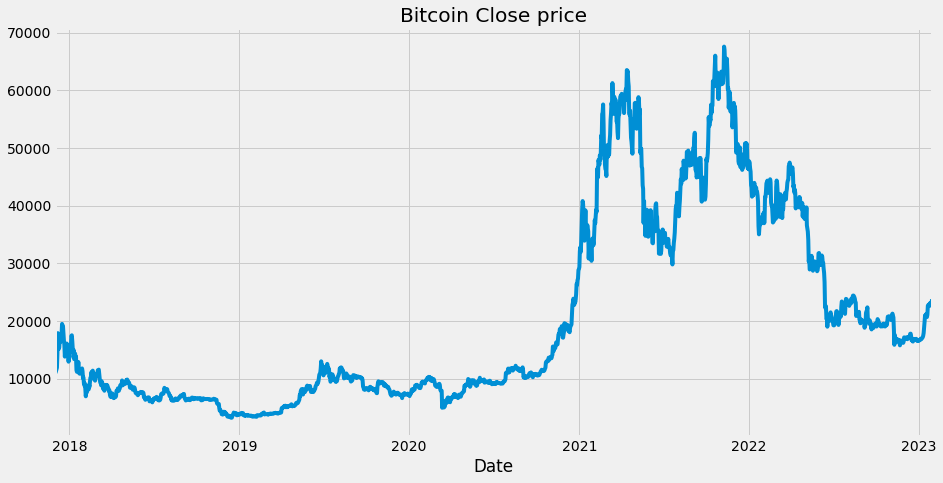

In [28]:
crypto_btc.set_index('Date').Close.plot(figsize=(14,7), title ='Bitcoin Close price', grid=True)

In [29]:
# Data Cleaning
missing_values = crypto_btc.isnull().sum()
missing_per = (missing_values/crypto_btc.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0


In [30]:
crypto_btccrypto_btc = crypto_btc.set_index('Date')
crypto_btc

,Date,Open,High,Low,Close,Volume
0,2017-12-01 00:00:00+00:00,10198.60,11046.70,9694.65,10975.60,6783119872
1,2017-12-02 00:00:00+00:00,10978.30,11320.20,10905.10,11074.60,5138500096
2,2017-12-03 00:00:00+00:00,11082.70,11858.70,10862.00,11323.20,6608309760
3,2017-12-04 00:00:00+00:00,11315.40,11657.20,11081.80,11657.20,6132409856
4,2017-12-05 00:00:00+00:00,11685.70,12032.00,11604.60,11916.70,6895260160
...,...,...,...,...,...,...
1881,2023-01-25 00:00:00+00:00,22639.27,23722.10,22406.08,23117.86,30685366709
1882,2023-01-26 00:00:00+00:00,23108.96,23237.08,22911.37,23032.78,26357839322
1883,2023-01-27 00:00:00+00:00,23030.72,23417.72,22654.59,23078.73,25383335641
1884,2023-01-28 00:00:00+00:00,23079.96,23165.90,22908.85,23031.09,14712928379


In [31]:
# Interactive plot of time series with range slider
crypto_btc.reset_index(inplace=True)
fig = px.line(crypto_btc, x='Date', y='Close', title='Close Price with Range Slider')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

In [32]:
# Feature Engineering

rolling_features = ["Open","High", "Low","Close", "Volume"]
window1 = 3 
window2 = 7
window3 = 30

# First convert our original df to a rolling df of 3d, 7d  and 30d
crypto_btc_rolled_3d = crypto_btc[rolling_features].rolling(window=window1, min_periods=0)
crypto_btc_rolled_7d = crypto_btc[rolling_features].rolling(window=window2, min_periods=0)
crypto_btc_rolled_30d = crypto_btc[rolling_features].rolling(window=window3, min_periods=0)

# rolling mean
crypto_btc_mean_3d = crypto_btc_rolled_3d.mean().shift(1).reset_index()
crypto_btc_mean_7d = crypto_btc_rolled_7d.mean().shift(1).reset_index()
crypto_btc_mean_30d = crypto_btc_rolled_30d.mean().shift(1).reset_index()


# Just print to see the structure of one of them
crypto_btc_mean_30d

,index,Open,High,Low,Close,Volume
0,0,NaN,NaN,NaN,NaN,NaN
1,1,10198.600000,11046.700000,9694.650000,10975.600000,6.783120e+09
2,2,10588.450000,11183.450000,10299.875000,11025.100000,5.960810e+09
3,3,10753.200000,11408.533333,10487.250000,11124.466667,6.176643e+09
4,4,10893.750000,11470.700000,10635.887500,11257.650000,6.165585e+09
...,...,...,...,...,...,...
1881,1881,18670.971000,19010.706000,18530.581667,18857.992000,2.008898e+10
1882,1882,18864.205000,19237.438667,18717.038667,19064.594000,2.071559e+10
1883,1883,19070.527333,19446.679667,18926.015333,19275.114333,2.106923e+10
1884,1884,19281.004667,19668.331333,19131.249667,19492.653000,2.134849e+10


In [33]:
# rolling stadard deviation
crypto_btc_std_3d = crypto_btc_rolled_3d.std().shift(1).reset_index()
crypto_btc_std_7d = crypto_btc_rolled_7d.std().shift(1).reset_index()
crypto_btc_std_30d = crypto_btc_rolled_30d.std().shift(1).reset_index()

# Print to see the structure of one of them
crypto_btc_std_30d

,index,Open,High,Low,Close,Volume
0,0,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN
2,2,551.331157,193.393705,855.917403,70.003571,1.162922e+09
3,3,483.125977,413.144144,686.749934,179.085045,9.032970e+08
4,4,484.380377,359.514719,634.656921,303.862090,7.378705e+08
...,...,...,...,...,...,...
1881,1881,2351.239694,2537.719931,2279.910213,2434.544918,8.228152e+09
1882,1882,2432.570019,2646.045217,2361.808019,2525.679256,8.297492e+09
1883,1883,2522.742716,2707.214947,2447.678417,2585.764422,8.304579e+09
1884,1884,2582.266331,2752.191814,2494.711642,2623.072061,8.304080e+09


In [34]:
# Adding additional features into Dataframe
for feature in rolling_features:
    crypto_btc[f"{feature}_mean_lag{window1}"] = crypto_btc_mean_3d[feature]
    crypto_btc[f"{feature}_mean_lag{window2}"] = crypto_btc_mean_7d[feature]
    crypto_btc[f"{feature}_mean_lag{window3}"] = crypto_btc_mean_30d[feature]
    
    crypto_btc[f"{feature}_std_lag{window1}"] = crypto_btc_std_3d[feature]
    crypto_btc[f"{feature}_std_lag{window2}"] = crypto_btc_std_7d[feature]
    crypto_btc[f"{feature}_std_lag{window3}"] = crypto_btc_std_30d[feature]

crypto_btc.fillna(crypto_btc.mean(), inplace=True)

crypto_btc.set_index("Date", drop=False, inplace=True)
crypto_btc.head()

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:11: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,index,Date,Open,High,Low,Close,Volume,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01 00:00:00+00:00,0,2017-12-01 00:00:00+00:00,10198.6,11046.7,9694.65,10975.6,6783119872,20238.548681,20225.642818,20181.996514,...,20188.632845,507.468517,781.314637,1638.160870,2.630511e+10,2.628419e+10,2.619835e+10,4.359727e+09,5.520260e+09,7.357907e+09
2017-12-02 00:00:00+00:00,1,2017-12-02 00:00:00+00:00,10978.3,11320.2,10905.10,11074.6,5138500096,10198.600000,10198.600000,10198.600000,...,10975.600000,507.468517,781.314637,1638.160870,6.783120e+09,6.783120e+09,6.783120e+09,4.359727e+09,5.520260e+09,7.357907e+09
2017-12-03 00:00:00+00:00,2,2017-12-03 00:00:00+00:00,11082.7,11858.7,10862.00,11323.2,6608309760,10588.450000,10588.450000,10588.450000,...,11025.100000,70.003571,70.003571,70.003571,5.960810e+09,5.960810e+09,5.960810e+09,1.162922e+09,1.162922e+09,1.162922e+09
2017-12-04 00:00:00+00:00,3,2017-12-04 00:00:00+00:00,11315.4,11657.2,11081.80,11657.2,6132409856,10753.200000,10753.200000,10753.200000,...,11124.466667,179.085045,179.085045,179.085045,6.176643e+09,6.176643e+09,6.176643e+09,9.032970e+08,9.032970e+08,9.032970e+08
2017-12-05 00:00:00+00:00,4,2017-12-05 00:00:00+00:00,11685.7,12032.0,11604.60,11916.7,6895260160,11125.466667,10893.750000,10893.750000,...,11257.650000,292.341330,303.862090,303.862090,5.959740e+09,6.165585e+09,6.165585e+09,7.499642e+08,7.378705e+08,7.378705e+08


In [35]:
# Data Splitting
crypto_btc_train = crypto_btc[crypto_btc.Date < "06-30-2021"]
crypto_btc_valid = crypto_btc[crypto_btc.Date >= "06-30-2021"]

print('train shape :', crypto_btc_train.shape)
print('validation shape :', crypto_btc_valid.shape)

train shape : (1307, 37)
validation shape : (579, 37)


In [36]:
# Model Building 
features = ['Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30']

In [37]:
X_train, y_train = crypto_btc_train[features], crypto_btc_train.Close
X_test, y_test = crypto_btc_valid[features], crypto_btc_valid.Close

In [38]:
reg = xgb.XGBRegressor()

In [39]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [40]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [41]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                                              0.8, 0.9, 1],
                              

In [42]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")
model.best_estimator_

Model Best Score : -0.08118312381495044
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 0.8, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 7, 'max_leaves': 0, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 733, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.3, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=733, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [43]:
# Plot Train 
crypto_btc_train['Predicted_Close_Price'] = model.predict(X_train)
fig = px.line(crypto_btc_train, x='Date', y=['Close' ,'Predicted_Close_Price'], title='Close Price with Range Slider')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            ])
            )
            )
fig.show()

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
# Plot Test and Train data
crypto_btc_valid['Forecast_XGBoost'] = model.predict(X_test)
overall_data = pd.concat([crypto_btc_train, crypto_btc_valid], sort=False)
fig = px.line(overall_data, x='Date', y=['Close' ,'Forecast_XGBoost'], title='Close Price with Range Slider')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            ])
            )
            )
fig.show()

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
# Review Test on Actual Close and the predicted Close
crypto_btc_valid[['Close', 'Forecast_XGBoost']]

,Close,Forecast_XGBoost
Date,,
2021-06-30 00:00:00+00:00,35040.84,34406.531250
2021-07-01 00:00:00+00:00,33572.12,35347.273438
2021-07-02 00:00:00+00:00,33897.05,35279.382812
2021-07-03 00:00:00+00:00,34668.55,34791.539062
2021-07-04 00:00:00+00:00,35287.78,33859.417969
...,...,...
2023-01-25 00:00:00+00:00,23117.86,26544.654297
2023-01-26 00:00:00+00:00,23032.78,26175.498047
2023-01-27 00:00:00+00:00,23078.73,26591.052734


In [46]:
# Plot the Test DataFrame
fig = px.line(crypto_btc_valid, x='Date', y=['Close' ,'Forecast_XGBoost'], title='Close Price with Range Slider')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            ])
            )
            )
fig.show()

In [47]:
# Calculate Mean Absolute Error, Mean Squared Errors, R2 Score
train_mae_xgboost = mean_absolute_error(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price'])
train_rmse_xgboost = np.sqrt(mean_squared_error(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price']))
train_r_square_xgboost = r2_score(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price'])

print(f"train Mean Absolute Error : {train_mae_xgboost}")
print(f"train Mean Squared Error : {train_rmse_xgboost}")
print(f"train R2 score : {train_r_square_xgboost}")

train Mean Absolute Error : 127.84808622889965
train Mean Squared Error : 194.35164836835412
train R2 score : 0.9998006981232105


In [48]:
# Calculate Mean Absolute Error, Mean Squared Errors, R2 Score
test_mae_xgboost = mean_absolute_error(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost'])
test_rmse_xgboost = np.sqrt(mean_squared_error(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost']))
test_r2_xgboost = r2_score(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost'])

print(f"test Mean Absolute Error  : {test_mae_xgboost}")
print(f"test Mean Squeared Error : {test_rmse_xgboost}")
print(f"test R2 Score : {test_r2_xgboost}")

test Mean Absolute Error  : 2380.033884053864
test Mean Squeared Error : 2994.366795506619
test R2 Score : 0.9540293546408455
